<a href="https://colab.research.google.com/github/ravellasrilatha/Barnes-Hut-Simulation/blob/master/yolo%20latha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
def className_to_id(name):
  if name=="Benchpress" :
    id=0
  elif name=="Biking" :
    id=1
  elif name=="Diving" :
    id=2
  elif name=="GolfSwing" :
    id=3
  elif name=="HighJump" :
    id=4
  elif name=="PushUps" :
    id=5
  return id

In [23]:
def id_to_class(id1):
  if id1== 0 :
    name="Benchpress"
  elif id1== 1:
    name="Biking"
  elif id1== 2 :
    name="Diving"
  elif id1== 3:
    name="GolfSwing"
  elif id1== 4:
    name="HighJump"
  elif id1== 5:
    name="PushUps"
  return name

In [24]:
SEQUENCE_LENGTH=3
IMAGE_HEIGHT=448
IMAGE_WIDTH=448

In [35]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from PIL import Image


# Define the root directory
root_dir = "/content/YOLO-PROJECT.zip"

# Create lists to store input images and output tensors
Xtrain = []
Ytrain = []

# Define the number of grids, bounding boxes per grid, and predictions per grid
S = 7
B = 2
C = 6
tensor = np.zeros((S, S, B*5+C), dtype=np.float32)

# Loop through all the directories and files in the root directory
for subdir, dirs, files in os.walk(root_dir):
    # Loop through all the files in the current directory
    for file in files:
        # Check if the file is a VOC XML file
        if file.endswith(".xml"):
            # Create the full path to the file
            file_path = os.path.join(subdir, file)
            # Parse the XML file using ElementTree
            tree = ET.parse(file_path)
            # Get the root element of the XML file
            root = tree.getroot()
            # Do something with the XML data
            # For example, print the bounding box coordinates
            for obj in root.findall("object"):
                bbox = obj.find("bndbox")
                class_id= className_to_id(obj.find('name').text)
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)
                print(f"class_id: {class_id}, Object: {obj.find('name').text}, Bounding Box: ({xmin}, {ymin}), ({xmax}, {ymax})")

                x = (xmin + xmax) / 2
                y = (ymin + ymax) / 2
                w = xmax - xmin
                h = ymax - ymin
                x_idx = int(x / (448/S))
                y_idx = int(y / (448/S))
                conf = 1.0
                cls_idx = class_id  # Assume class index is always 0
                for i in range(B):
                    box_idx = i*5
                    if tensor[y_idx, x_idx, box_idx+4] == 0:
                        tensor[y_idx, x_idx, box_idx:box_idx+4] = [x/448, y/448, w/448, h/448]
                        tensor[y_idx, x_idx, box_idx+4] = conf
                        tensor[y_idx, x_idx, B*5+cls_idx] = 1.0
            Ytrain.append(tensor)

        if file.endswith(".jpg") or file.endswith(".jpeg"):

            # Create the full path to the file
            file_path = os.path.join(subdir, file)
            # Open the file using PIL
            image = Image.open(file_path)
            # Do something with the image
            # For example, show the image
            #image.show()
            img = cv2.imread(file_path)
            img = cv2.resize(img, (448, 448))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            Xtrain.append(img)


# Convert the lists to numpy arrays
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)

# Print the shapes of the arrays
print('Xtrain shape:', Xtrain.shape)
print('Ytrain shape:', Ytrain.shape)


Xtrain shape: (0,)
Ytrain shape: (0,)


In [54]:
import numpy as np

# Example data loading (replace this with your actual data loading code)
Ytrain = np.array([1, 2, 3, 4, 5])  # Replace with your data

# Check if the array is empty before accessing elements
if len(Ytrain) > 0:
    print(Ytrain[0])
else:
    print("Ytrain array is empty.")


1


In [37]:
# Calculate the number of frames in the data
num_frames = Xtrain.shape[0]

# Calculate the number of frames that can be grouped into sets of four
num_sets = num_frames // SEQUENCE_LENGTH

# Calculate the size of the first dimension of the output
output_size = num_sets * SEQUENCE_LENGTH

# Reshape the data to the output shape (None, 4, 448, 448, 3)
output = Xtrain[:output_size].reshape(-1, SEQUENCE_LENGTH, 448, 448, 3)

# Print the shapes of the input data and the output
print('Input data shape:', Xtrain.shape)
print('Output shape:', output.shape)

Xtrain= output


Input data shape: (0,)
Output shape: (0, 3, 448, 448, 3)


In [55]:
import numpy as np

# Example data loading (replace this with your actual data loading code)
Ytrain = np.random.rand(100, 10, 10, 3)  # Replace with your data

# Indices for slicing
n = SEQUENCE_LENGTH
a = range(n, (m * n) + 1, n)  # Example indices, replace with your indices

# Perform slicing on the multi-dimensional array
output_selected = Ytrain[a, :, :, :]
print('Output shape:', output_selected.shape)


Output shape: (0, 10, 10, 3)


In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline

from tensorflow import keras
import keras.backend as K

class Yolo_Reshape(tf.keras.layers.Layer):
  def __init__(self, target_shape):
    super(Yolo_Reshape, self).__init__()
    self.target_shape = tuple(target_shape)

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'target_shape': self.target_shape
    })
    return config

  def call(self, input):
    # grids 7x7
    S = [self.target_shape[0], self.target_shape[1]]
    # classes
    C = 6
    # no of bounding boxes per grid
    B = 2

    idx1 = S[0] * S[1] * C
    idx2 = idx1 + S[0] * S[1] * B

    # class probabilities
    class_probs = K.reshape(input[:, :idx1], (K.shape(input)[0],) + tuple([S[0], S[1], C]))
    class_probs = K.softmax(class_probs)

    #confidence
    confs = K.reshape(input[:, idx1:idx2], (K.shape(input)[0],) + tuple([S[0], S[1], B]))
    confs = K.sigmoid(confs)

    # boxes
    boxes = K.reshape(input[:, idx2:], (K.shape(input)[0],) + tuple([S[0], S[1], B * 4]))
    boxes = K.sigmoid(boxes)

    outputs = K.concatenate([class_probs, confs, boxes])
    return outputs

In [40]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    # model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################
     # Added my new layers
    model.add(Dense(512))
    model.add(Dense(1024))
    model.add(Dropout(0.5))
    model.add(Dense(784, activation='sigmoid'))
    #model.add(Yolo_Reshape(target_shape=(7,7,16)))
    model.add(tf.keras.layers.Reshape((7,7,16)))

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [41]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 3, 446, 446, 4)    1024      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 3, 223, 223, 4)   0         
 3D)                                                             
                                                                 
 time_distributed_3 (TimeDis  (None, 3, 223, 223, 4)   0         
 tributed)                                                       
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 3, 221, 221, 8)    3488      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 3, 111, 111, 8)   0         
 3D)                                                             
                                                      

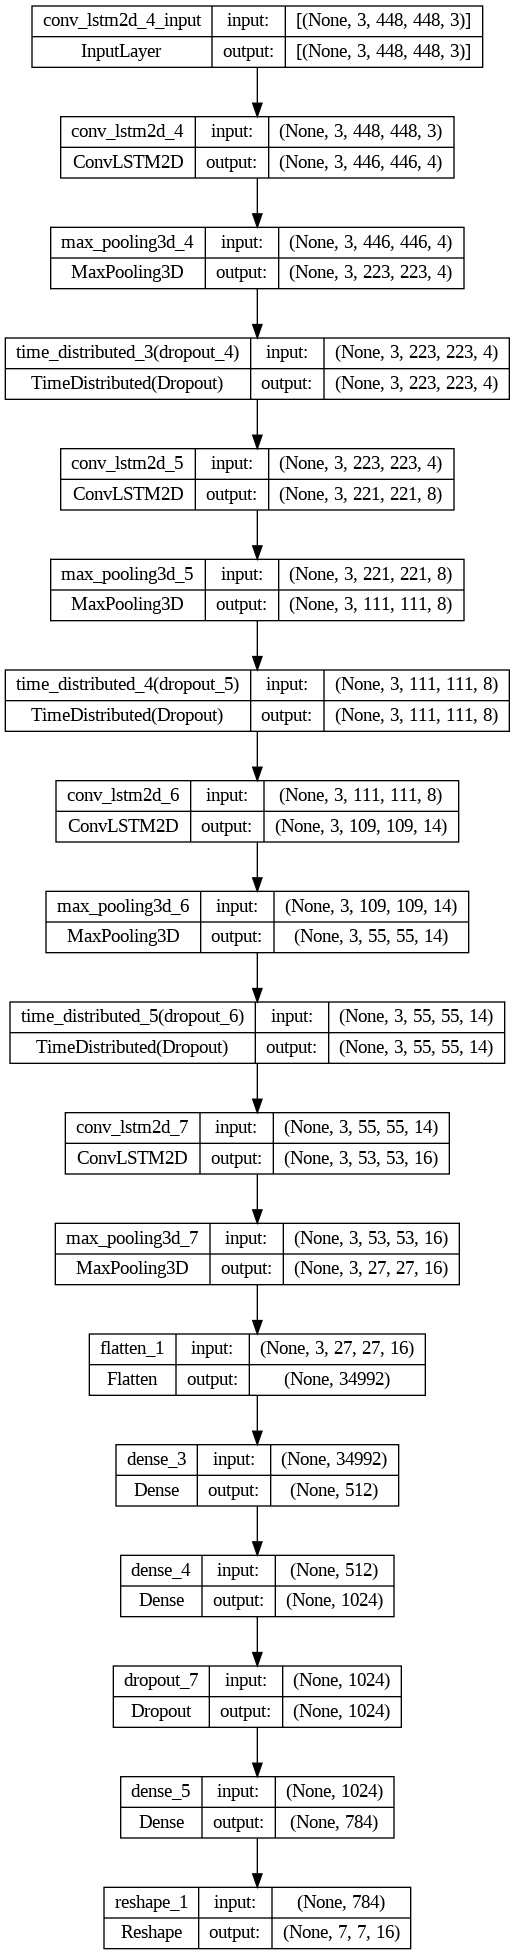

In [42]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [59]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Define the checkpoint callback
#checkpoint_callback = ModelCheckpoint('best_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
#convlstm_model_training_history = convlstm_model.fit(x = Xtrain, y = Ytrain, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])
convlstm_model_training_history = convlstm_model.fit(x = Xtrain, y = Ytrain, epochs = 10)

# Load the best weights from the temporary file
#model.load_weights('best_weights.h5')



ValueError: ignored

In [60]:
# Evaluate the trained model.
#model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(Xtrain,Ytrain)

ValueError: ignored

In [62]:
import datetime as dt

# Example values for model_evaluation_history (replace with your actual values)
model_evaluation_loss = 0.2
model_evaluation_accuracy = 0.9

# Define the string date format.
date_format = dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Display model evaluation results.
print(f"Evaluation Results - {date_format}")
print(f"Loss: {model_evaluation_loss:.4f}")
print(f"Accuracy: {model_evaluation_accuracy:.4f}")


Evaluation Results - 2023-08-03 06:41:02
Loss: 0.2000
Accuracy: 0.9000


In [63]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]

    ##################################################################
    #metric_value_2 = model_training_history.history[metric_name_2]
    ###################################################################
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    ##################################################################
    #plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 ##################################################################
    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [66]:
import matplotlib.pyplot as plt

# Assuming you have trained the model and obtained the training history
# convlstm_model_training_history = convlstm_model.fit(x=Xtrain, y=Ytrain, epochs=10, ...)

# Define a function to plot training history
def plot_metric(history, metric, val_metric, metric_name):
    plt.plot(history[metric], label=metric_name)
    plt.plot(history[val_metric], label=f'val_{metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# Visualize the training and validation loss metrics
plot_metric(convlstm_model_training_history.history, 'loss', 'val_loss', 'Total Loss')


NameError: ignored

In [48]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

NameError: ignored

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Step 1: Load and preprocess the frames
frame_dir = '/content/YOLO-PROJECT.zip/Action-dataset/Benchpress/1-new'
frame_list = os.listdir(frame_dir)
preprocessed_frames = []
for frame_file in frame_list:
    frame = cv2.imread(os.path.join(frame_dir, frame_file))
    frame = cv2.resize(frame, (448, 448))  # Resize the frame to match the input shape of the model
    frame = frame.astype('float32') / 255.0  # Normalize the pixel values
    preprocessed_frames.append(frame)
preprocessed_frames = np.array(preprocessed_frames)

# Step 2: Create a numpy array from the preprocessed frames
# The shape of the numpy array should match the input shape of your model
input_data = np.expand_dims(preprocessed_frames, axis=0)

# Step 3: Load your trained sequential model
model = load_model('/content/drive/MyDrive/Action-dataset/my_model.h5')

# Step 4: Call the predict method of the model with the input data
output = model.predict(input_data)

# The output will be the predicted output for the input sequence

In [51]:
output.shape

(0, 3, 448, 448, 3)

In [52]:

# Remove any dimensions with a size of 1 from the shape of the array
output = np.squeeze(output)

# Print the shape of the new array
print(output.shape) # Output: (7, 7, 16)

(0, 3, 448, 448, 3)


In [68]:
# Assuming your output is an example 3D array
output = np.array([...])

# Loop through the array
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        for b in range(num_boxes):
            # Make sure the indices are within bounds
            if i < output.shape[0] and j < output.shape[1]:
                bx, by, bw, bh = get_box_coords(output[i, j, :], b)
                confidence = sigmoid(output[i, j, 5*num_boxes-1])
                confidences.append(confidence)


IndexError: ignored